In [1]:
!pip install tensorflow-datasets

In [2]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


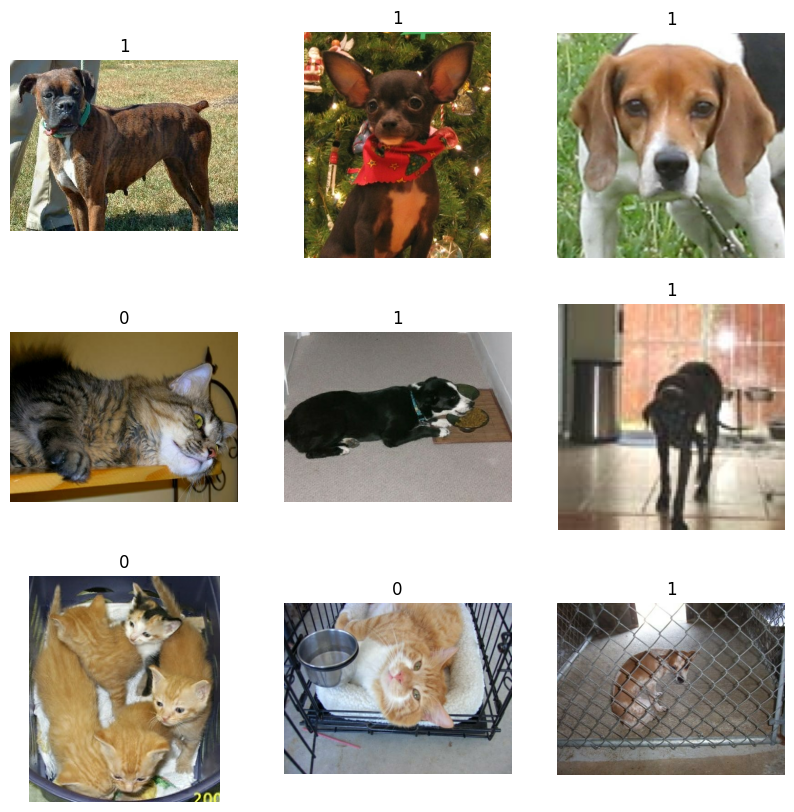

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [6]:
import keras
#Let's resize images to 150x150:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

In [10]:
#Using random data augmentation

from tensorflow.keras import layers
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [11]:
#Let's batch the data and use prefetching to optimize loading speed.

from tensorflow import data as tf_data

batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

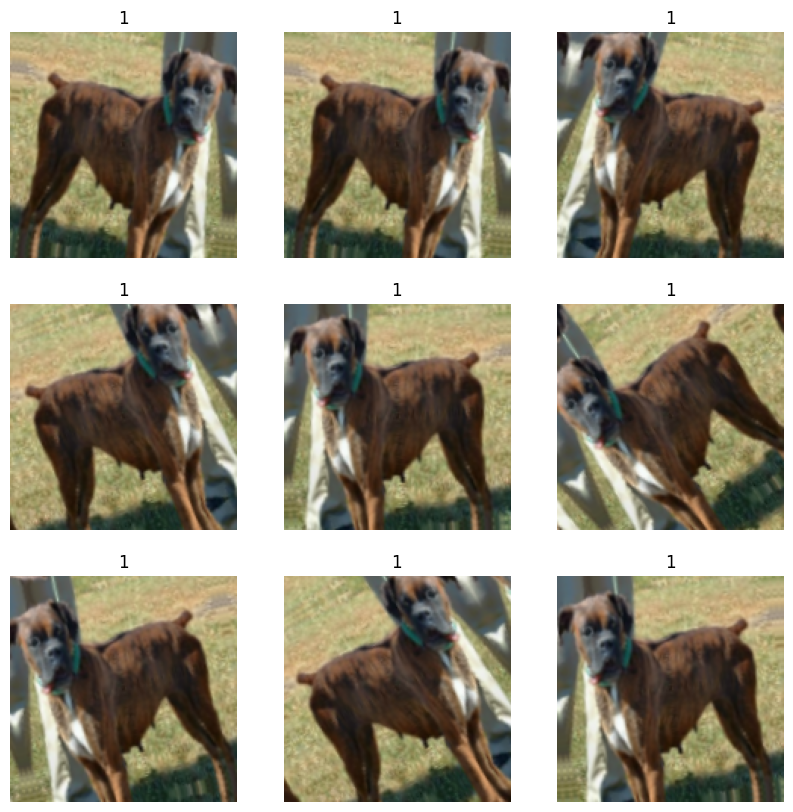

In [13]:
#Let's visualize what the first image of the first batch looks like after various random transformations:
import numpy as np
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [15]:
base_model = keras.applications.Xception(
    weights="imagenet",# Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)

In [16]:
base_model.trainable = False

In [17]:
# create new model on top
inputs = keras.Input(shape=(150, 150, 3))

scale_layer = keras.layers.Rescaling(scale=1/127.5, offset=-1)
x = scale_layer(inputs)

# base_model is running in inference mode here.
"""

Inference mode: After the model has been trained, inference mode refers to using the trained model to make predictions on new data. Here, you typically feed the input data directly into the model and obtain predictions (outputs) from the model.

"""
x = base_model(x, training=False)

"""

GlobalAveragePooling2D: is a pooling operation that calculates the average value of each feature map across the spatial dimensions (height and width) of the input.
For each feature map, it computes the average of all values in that feature map, resulting in a single value per feature map.

"""
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [18]:
model.summary(show_trainable=True)


Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        2086148   N          
                                                       0                    
                                                                            
 global_average_pooling2d (  (None, 2048)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 2048)              0     

In [19]:
#Train the top layer

model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.BinaryCrossentropy(from_logits=True),     metrics=[keras.metrics.BinaryAccuracy()],)

# Two epochs are sufficient!
epochs = 2

print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)


Fitting the top layer of the model
Epoch 1/2
146/146 [==============================] - 1305s 9s/step - loss: 0.2697 - binary_accuracy: 0.8725 - val_loss: 0.0929 - val_binary_accuracy: 0.9673
Epoch 2/2
146/146 [==============================] - 1183s 8s/step - loss: 0.1846 - binary_accuracy: 0.9160 - val_loss: 0.0844 - val_binary_accuracy: 0.9690


In [20]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
print("Fitting the end-to-end model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        2086148   Y          
                                                       0                    
                                                                            
 global_average_pooling2d (  (None, 2048)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 2048)              0     

In [23]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
37/37 [==============================] - 231s 6s/step - loss: 0.0722 - binary_accuracy: 0.9712


[0.07220461219549179, 0.9711951613426208]

In [24]:
fine_tuned_model = model.save("my_fine_tuned_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np

img_path = "/content/test_cat1.jpg"
img = image.load_img(img_path, target_size=(150, 150))

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale the same way as during training
    return img_array

def predict_image(img_path, model):
    img_array = preprocess_image(img_path)
    model = load_model('my_fine_tuned_model.h5')
    prediction = model.predict(img_array)
    if prediction > 0.5:
        print("Predicted class: Dog")
    else:
        print("Predicted class: Cat")

predict_image(img_path, model)


1/1 [==============================] - 3s 3s/step
Predicted class: Cat
